# Notebook 1.

In [2]:
import pandas as pd
pd.set_option("display.float_format", "{:.2f}".format)

path = r"C:\Users\HP\Downloads\penguins_classification.csv"
penguins = pd.read_csv(path)
culmen_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_column = "Species"

In [3]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Culmen Length (mm)  342 non-null    float64
 1   Culmen Depth (mm)   342 non-null    float64
 2   Species             342 non-null    object 
dtypes: float64(2), object(1)
memory usage: 8.1+ KB


In [4]:
from sklearn.model_selection import train_test_split

data, target = penguins[culmen_columns], penguins[target_column]
data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0
)

In [5]:
from sklearn.linear_model import LogisticRegression

linear_model = LogisticRegression()
linear_model.fit(data_train, target_train)

LogisticRegression()

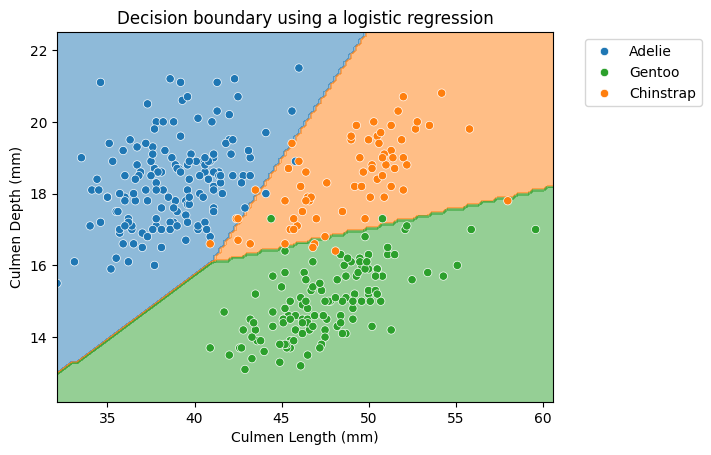

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.inspection import DecisionBoundaryDisplay

tab10_norm = mpl.colors.Normalize(vmin=-0.5, vmax=8.5)
# create a palette to be used in the scatterplot
palette = ["tab:blue", "tab:green", "tab:orange"]

dbd = DecisionBoundaryDisplay.from_estimator(
    linear_model,
    data_train,
    response_method="predict",
    cmap="tab10",
    norm=tab10_norm,
    alpha=0.5,
)
sns.scatterplot(
    data=penguins,
    x=culmen_columns[0],
    y=culmen_columns[1],
    hue=target_column,
    palette=palette,
)
# put the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
_ = plt.title("Decision boundary using a logistic regression")

In [7]:
linear_model.fit(data_train, target_train)
test_score = linear_model.score(data_test, target_test)
print(f"Accuracy of the LogisticRegression: {test_score:.2f}")

Accuracy of the LogisticRegression: 0.98


Unlike linear models, the decision rule for the decision tree is not
controlled by a simple linear combination of weights and feature values.

Instead, the decision rules of trees can be defined in terms of
- the feature index used at each split node of the tree,
- the threshold value used at each split node,
- the value to predict at each leaf node.

Decision trees partition the feature space by considering a single feature at
a time. The number of splits depends on both the hyperparameters and the
number of data points in the training set: the more flexible the
hyperparameters and the larger the training set, the more splits can be
considered by the model.

As the number of adjustable components taking part in the decision rule
changes with the training size, we say that decision trees are non-parametric
models.

Let's now visualize the shape of the decision boundary of a decision tree when
we set the `max_depth` hyperparameter to only allow for a single split to
partition the feature space.

In [8]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=1)
tree.fit(data_train, target_train)

DecisionTreeClassifier(max_depth=1)

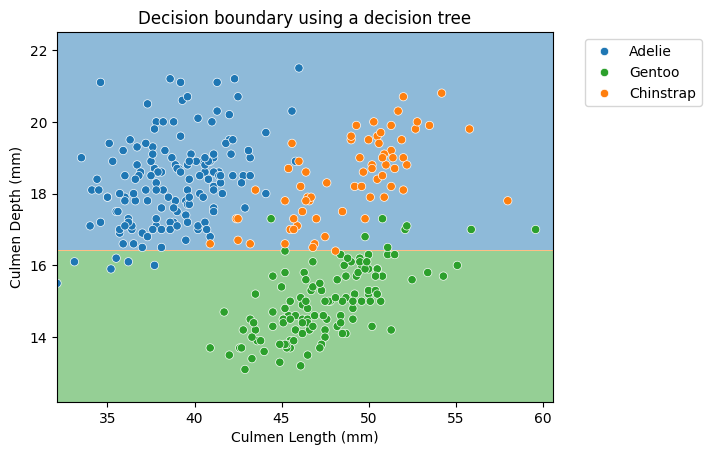

In [9]:
DecisionBoundaryDisplay.from_estimator(
    tree,
    data_train,
    response_method="predict",
    cmap="tab10",
    norm=tab10_norm,
    alpha=0.5,
)
sns.scatterplot(
    data=penguins,
    x=culmen_columns[0],
    y=culmen_columns[1],
    hue=target_column,
    palette=palette,
)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
_ = plt.title("Decision boundary using a decision tree")

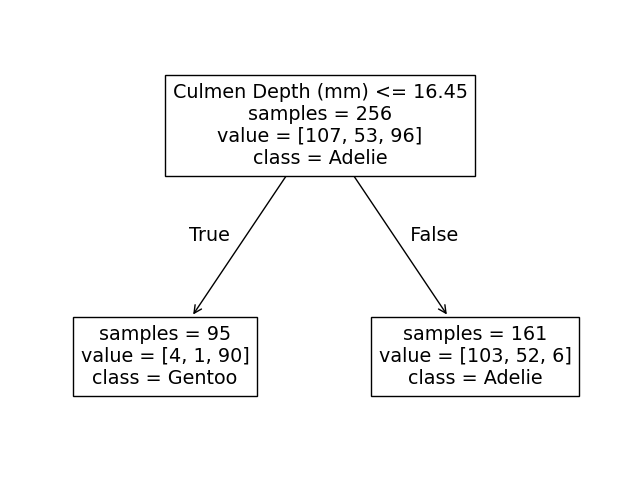

In [10]:
from sklearn.tree import plot_tree

_, ax = plt.subplots(figsize=(8, 6))
_ = plot_tree(
    tree,
    feature_names=culmen_columns,
    class_names=tree.classes_.tolist(),
    impurity=False,
    ax=ax,
)

We see that the split was done on the culmen depth feature. The original
dataset was subdivided into 2 sets based on the culmen depth (inferior or
superior to 16.45 mm).

This partition of the dataset minimizes the class diversity in each
sub-partitions. This measure is also known as a **criterion**, and is a
settable parameter.

If we look more closely at the partition, we see that the sample superior to
16.45 belongs mainly to the "Adelie" class. Looking at the values, we indeed
observe 103 "Adelie" individuals in this space. We also count 52 "Chinstrap"
samples and 6 "Gentoo" samples. We can make similar interpretation for the
partition defined by a threshold inferior to 16.45mm. In this case, the most
represented class is the "Gentoo" species.

Let's see how our tree would work as a predictor. Let's start with a case
where the culmen depth is inferior to the threshold.

In [11]:
test_penguin_1 = pd.DataFrame(
    {"Culmen Length (mm)": [0], "Culmen Depth (mm)": [15]}
)
tree.predict(test_penguin_1)

array(['Gentoo'], dtype=object)

In [12]:
test_penguin_2 = pd.DataFrame(
    {"Culmen Length (mm)": [0], "Culmen Depth (mm)": [17]}
)
tree.predict(test_penguin_2)

array(['Adelie'], dtype=object)

Thus, we can conclude that a decision tree classifier predicts the most
represented class within a partition.

During the training, we have a count of samples in each partition, we can also
compute the probability of belonging to a specific class within this
partition.

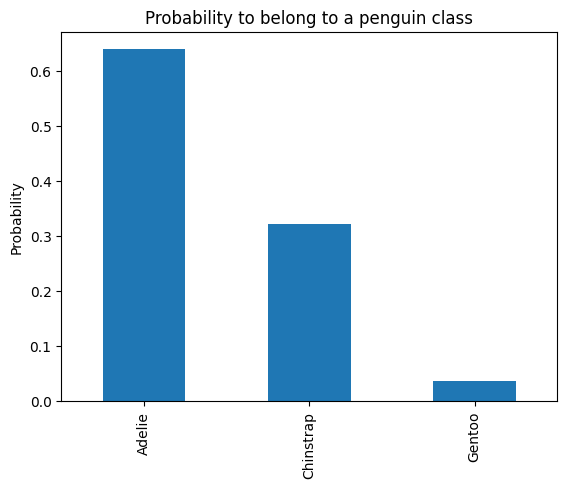

In [13]:
y_pred_proba = tree.predict_proba(test_penguin_2)
y_proba_class_0 = pd.Series(y_pred_proba[0], index=tree.classes_)

y_proba_class_0.plot.bar()
plt.ylabel("Probability")
_ = plt.title("Probability to belong to a penguin class")

In [14]:
adelie_proba = 103 / 161
chinstrap_proba = 52 / 161
gentoo_proba = 6 / 161
print(
    "Probabilities for the different classes:\n"
    f"Adelie: {adelie_proba:.3f}\n"
    f"Chinstrap: {chinstrap_proba:.3f}\n"
    f"Gentoo: {gentoo_proba:.3f}\n"
)

Probabilities for the different classes:
Adelie: 0.640
Chinstrap: 0.323
Gentoo: 0.037



It is also important to note that the culmen length has been disregarded for
the moment. It means that regardless of its value, it is not used during the
prediction.

In [15]:
test_penguin_3 = pd.DataFrame(
    {"Culmen Length (mm)": [10_000], "Culmen Depth (mm)": [17]}
)
tree.predict_proba(test_penguin_3)

array([[0.63975155, 0.32298137, 0.03726708]])

Going back to our classification problem, the split found with a maximum depth
of 1 is not powerful enough to separate the three species and the model
accuracy is low when compared to the linear model.

In [16]:
tree.fit(data_train, target_train)
test_score = tree.score(data_test, target_test)
print(f"Accuracy of the DecisionTreeClassifier: {test_score:.2f}")

Accuracy of the DecisionTreeClassifier: 0.78


# Notebook 2.

In [6]:
import pandas as pd
pd.set_option("display.float_format", "{:.2f}".format)

path = r"C:\Users\HP\Downloads\penguins_regression.csv"
penguins = pd.read_csv(path)
feature_name = "Flipper Length (mm)"
target_name = "Body Mass (g)"
data_train, target_train = penguins[[feature_name]], penguins[target_name]

In [7]:
import numpy as np

data_test = pd.DataFrame(
    np.arange(data_train[feature_name].min(), data_train[feature_name].max()),
    columns=[feature_name],
)

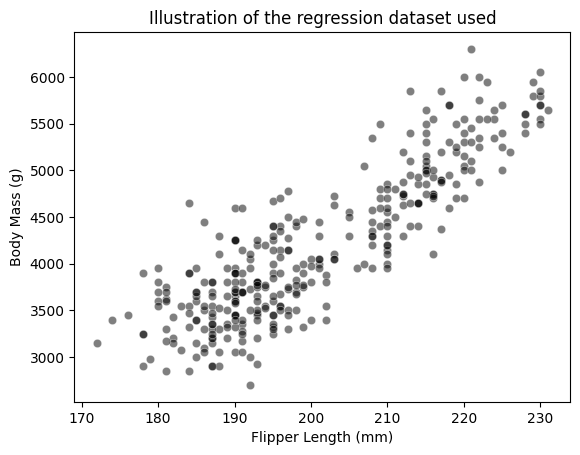

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(
    data=penguins, x=feature_name, y=target_name, color="black", alpha=0.5
)
_ = plt.title("Illustration of the regression dataset used")

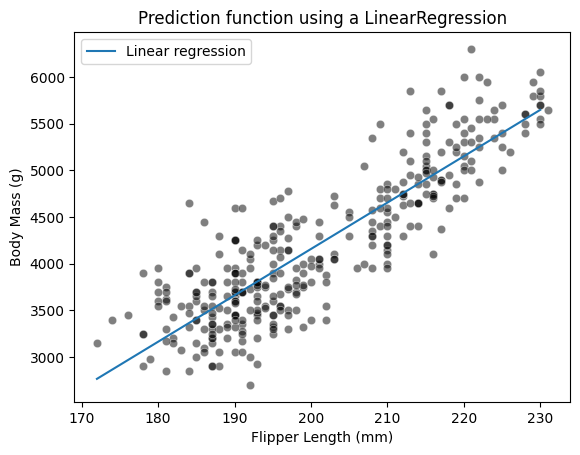

In [9]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(data_train, target_train)
target_predicted = linear_model.predict(data_test)

sns.scatterplot(
    data=penguins, x=feature_name, y=target_name, color="black", alpha=0.5
)
plt.plot(data_test[feature_name], target_predicted, label="Linear regression")
plt.legend()
_ = plt.title("Prediction function using a LinearRegression")

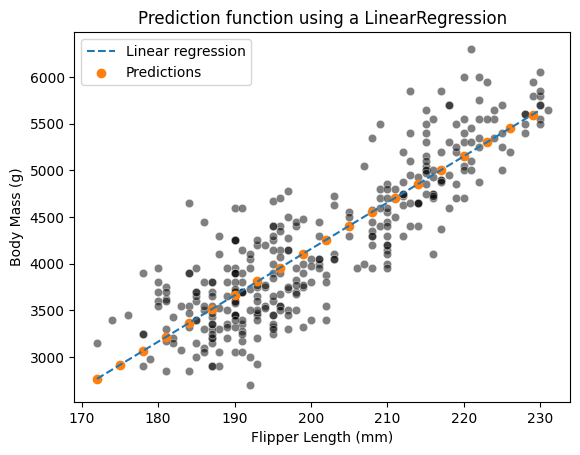

In [10]:
ax = sns.scatterplot(
    data=penguins, x=feature_name, y=target_name, color="black", alpha=0.5
)
plt.plot(
    data_test[feature_name],
    target_predicted,
    label="Linear regression",
    linestyle="--",
)
plt.scatter(
    data_test[::3],
    target_predicted[::3],
    label="Predictions",
    color="tab:orange",
)
plt.legend()
_ = plt.title("Prediction function using a LinearRegression")

Contrary to linear models, decision trees are non-parametric models: they do
not make assumptions about the way data is distributed. This affects the
prediction scheme. Repeating the above experiment highlights the differences.

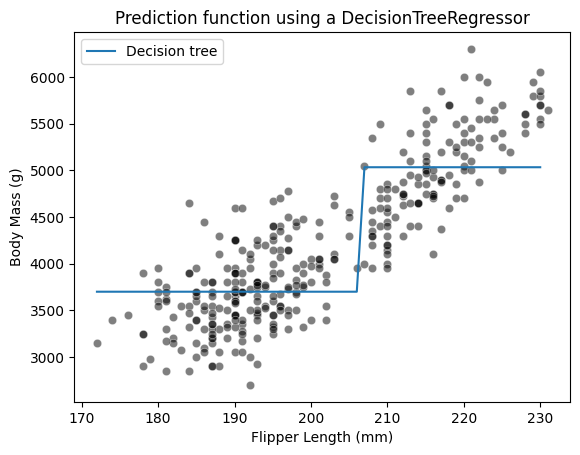

In [11]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=1)
tree.fit(data_train, target_train)
target_predicted = tree.predict(data_test)

sns.scatterplot(
    data=penguins, x=feature_name, y=target_name, color="black", alpha=0.5
)
plt.plot(data_test[feature_name], target_predicted, label="Decision tree")
plt.legend()
_ = plt.title("Prediction function using a DecisionTreeRegressor")

We see that the decision tree model does not have an *a priori* distribution
for the data and we do not end-up with a straight line to regress flipper
length and body mass.

Instead, we observe that the predictions of the tree are piecewise constant.
Indeed, our feature space was split into two partitions. Let's check the tree
structure to see what was the threshold found during the training.

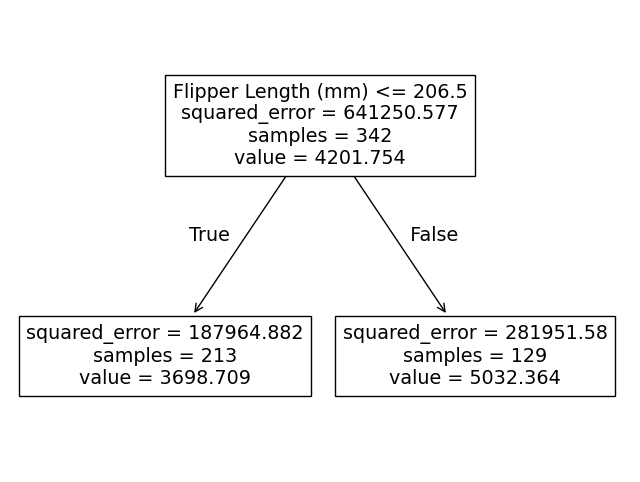

In [12]:
from sklearn.tree import plot_tree

_, ax = plt.subplots(figsize=(8, 6))
_ = plot_tree(tree, feature_names=[feature_name], ax=ax)

The threshold for our feature (flipper length) is 206.5 mm. The predicted
values on each side of the split are two constants: 3698.71 g and 5032.36 g.
These values corresponds to the mean values of the training samples in each
partition.

In classification, we saw that increasing the depth of the tree allowed us to
get more complex decision boundaries. Let's check the effect of increasing the
depth in a regression setting:

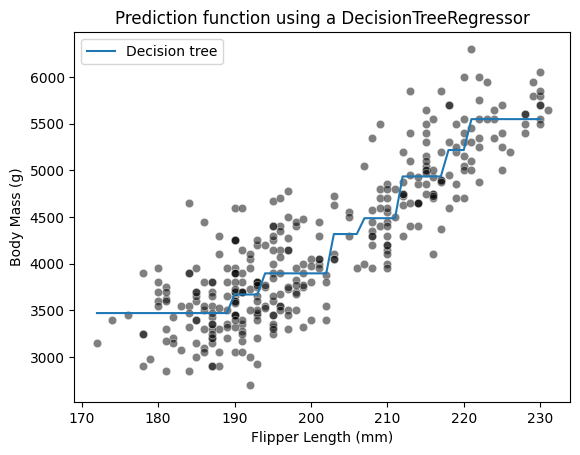

In [13]:
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(data_train, target_train)
target_predicted = tree.predict(data_test)

sns.scatterplot(
    data=penguins, x=feature_name, y=target_name, color="black", alpha=0.5
)
plt.plot(data_test[feature_name], target_predicted, label="Decision tree")
plt.legend()
_ = plt.title("Prediction function using a DecisionTreeRegressor")

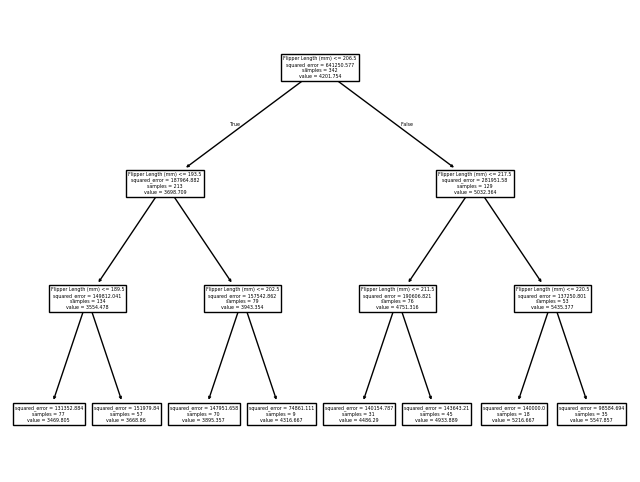

In [14]:
_, ax = plt.subplots(figsize=(8, 6))
_ = plot_tree(tree, feature_names=[feature_name], ax=ax)

# Notebook 3.

In [1]:
import pandas as pd
pd.set_option("display.float_format", "{:.2f}".format)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import DecisionBoundaryDisplay



path = r"C:\Users\HP\Downloads\penguins_regression.csv"
data_reg = pd.read_csv(path)

path = r"C:\Users\HP\Downloads\penguins_classification.csv"
data_clf = pd.read_csv(path)


data_clf_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_clf_column = "Species"

data_reg_columns = ["Flipper Length (mm)"]
target_reg_column = "Body Mass (g)"

In [2]:
def fit_and_plot_classification(model, data, feature_names, target_names):
    model.fit(data[feature_names], data[target_names])
    if data[target_names].nunique() == 2:
        palette = ["tab:red", "tab:blue"]
    else:
        palette = ["tab:red", "tab:blue", "black"]
    DecisionBoundaryDisplay.from_estimator(
        model,
        data[feature_names],
        response_method="predict",
        cmap="RdBu",
        alpha=0.5,
    )
    sns.scatterplot(
        data=data,
        x=feature_names[0],
        y=feature_names[1],
        hue=target_names,
        palette=palette,
    )
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")


def fit_and_plot_regression(model, data, feature_names, target_names):
    model.fit(data[feature_names], data[target_names])
    data_test = pd.DataFrame(
        np.arange(data.iloc[:, 0].min(), data.iloc[:, 0].max()),
        columns=data[feature_names].columns,
    )
    target_predicted = model.predict(data_test)

    sns.scatterplot(
        x=data.iloc[:, 0], y=data[target_names], color="black", alpha=0.5
    )
    plt.plot(data_test.iloc[:, 0], target_predicted, linewidth=4)

In [3]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

max_depth = 2
tree_clf = DecisionTreeClassifier(max_depth=max_depth)
tree_reg = DecisionTreeRegressor(max_depth=max_depth)

In [ ]:
fit_and_plot_classification(
    tree_clf, data_clf, data_clf_columns, target_clf_column
)
_ = plt.title(f"Shallow classification tree with max-depth of {max_depth}")

In [ ]:
    fit_and_plot_regression(
    tree_reg, data_reg, data_reg_columns, target_reg_column
)
_ = plt.title(f"Shallow regression tree with max-depth of {max_depth}")

In [ ]:
max_depth = 30
tree_clf = DecisionTreeClassifier(max_depth=max_depth)
tree_reg = DecisionTreeRegressor(max_depth=max_depth)

In [ ]:
fit_and_plot_classification(
    tree_clf, data_clf, data_clf_columns, target_clf_column
)
_ = plt.title(f"Deep classification tree with max-depth of {max_depth}")

In [ ]:
fit_and_plot_regression(
    tree_reg, data_reg, data_reg_columns, target_reg_column
)
_ = plt.title(f"Deep regression tree with max-depth of {max_depth}")